In [ ]:
from __future__ import annotations

from dataclasses import asdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# Import the implementation from the refactored script so the notebook stays in sync.
from main import (
    BacktestConfig,
    assign_state,
    backtest,
    build_transition_matrix,
    compute_velocity,
    load_data,
    plot_equity,
    plot_trades,
    plot_transition_heatmap,
    plot_transition_network,
    resolve_input_path,
)


def pretty_result(result) -> pd.DataFrame:
    """Return a 1-row DataFrame with rounded, labeled metrics."""
    d = asdict(result)
    df = pd.DataFrame([d])
    for col in ["final_balance", "total_profit", "roi_pct", "max_drawdown_pct", "win_rate_pct", "sharpe"]:
        if col in df.columns:
            df[col] = df[col].astype(float).round(2)
    if "total_trades" in df.columns:
        df["total_trades"] = df["total_trades"].astype(int)
    df = df.rename(
        columns={
            "final_balance": "Final Balance (USDT)",
            "total_profit": "Total Profit (USDT)",
            "roi_pct": "ROI (%)",
            "max_drawdown_pct": "Max Drawdown (%)",
            "total_trades": "Total Trades",
            "win_rate_pct": "Win Rate (%)",
            "sharpe": "Sharpe (daily scaled)",
        }
    )
    ordered = [
        "Final Balance (USDT)",
        "Total Profit (USDT)",
        "ROI (%)",
        "Max Drawdown (%)",
        "Total Trades",
        "Win Rate (%)",
        "Sharpe (daily scaled)",
    ]
    return df[[c for c in ordered if c in df.columns]]

# Markov Trading Backtest (Notebook)

This notebook is a **clean, linear walkthrough** of the same logic in `main.py`.

> Tip: if things look weird (old functions, repeated outputs), restart the kernel and run cells from top to bottom.

## Flow
1. Select dataset
2. Build velocity + states
3. Build transition matrix
4. Run backtest + view metrics
5. Plot charts (once)

In [ ]:
# 1) Select dataset + load
DATA_DIR = Path("data")
timestamp = 1738439134000
interval = "30m"
symbol = "BTCUSDT"

input_path = resolve_input_path(
    data_dir=DATA_DIR,
    timestamp=timestamp,
    interval=interval,
    symbol=symbol,
    prefer="parquet",
)
print("Using:", input_path)

df = load_data(input_path)
print("Rows:", len(df))
print("Range:", df["Open Time"].iloc[0], "→", df["Open Time"].iloc[-1])

df.head()

Using: data/1738439134000/30m/BTCUSDT.parquet
Rows: 95
Range: 2025-01-31 20:00:00 → 2025-02-02 19:00:00


,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
0,2025-01-31 20:00:00,102312.31,102312.31,101694.87,101938.43,967.73455,1738355399999,9.872080e+07,237037,421.74939,4.302120e+07,0
1,2025-01-31 20:30:00,101938.42,102321.42,101603.23,101680.02,1041.80582,1738357199999,1.061562e+08,218329,464.76875,4.735715e+07,0
2,2025-01-31 21:00:00,101680.02,101948.96,101608.00,101625.31,550.95546,1738358999999,5.604082e+07,113716,256.33945,2.607456e+07,0
3,2025-01-31 21:30:00,101625.32,102166.11,101560.00,102148.73,496.61921,1738360799999,5.060350e+07,93413,247.24282,2.518966e+07,0
4,2025-01-31 22:00:00,102148.72,102380.66,101918.46,102366.06,322.47520,1738362599999,3.293891e+07,62567,183.14705,1.870986e+07,0


In [ ]:
# 2) Build velocity + state labels
config = BacktestConfig(
    seed=7,
    velocity_window=3,
    high_quantile=0.75,
    low_quantile=0.25,
    initial_balance=1000.0,
    fee=0.001,
    trade_allocation=0.2,
    stop_loss_pct=0.02,
    take_profit_pct=0.04,
    save_outputs=False,
    show_plots=False,
)

df2 = compute_velocity(df, window=config.velocity_window)
df2 = assign_state(df2, high_quantile=config.high_quantile, low_quantile=config.low_quantile)

df2[["Open Time", "Close", "velocity", "state"]].tail(10)

,Open Time,Close,velocity,state
85,2025-02-02 14:30:00,99205.08,0.001595,High Up
86,2025-02-02 15:00:00,98826.35,0.000113,Low Up
87,2025-02-02 15:30:00,99346.87,-0.000244,Low Down
88,2025-02-02 16:00:00,98847.68,-0.001192,Low Down
89,2025-02-02 16:30:00,98264.00,-0.001888,High Down
90,2025-02-02 17:00:00,97848.01,-0.005054,High Down
91,2025-02-02 17:30:00,97228.85,-0.005489,High Down
92,2025-02-02 18:00:00,97831.99,-0.001453,Low Down
93,2025-02-02 18:30:00,97087.92,-0.002577,High Down
94,2025-02-02 19:00:00,97205.34,-0.000064,Low Down


In [33]:
# 3) Build transition matrix
transition_matrix = build_transition_matrix(df2["state"].values)
transition_matrix

next_state,High Down,High Up,Low Down,Low Up
state,,,,
High Down,0.625000,0.041667,0.333333,0.000000
High Up,0.000000,0.583333,0.208333,0.208333
Low Down,0.228571,0.171429,0.542857,0.057143
Low Up,0.000000,0.300000,0.400000,0.300000
Neutral,1.000000,0.000000,0.000000,0.000000


In [34]:
# 4) Run backtest + show metrics
rng = np.random.default_rng(config.seed)
result, trades_df, equity_df = backtest(df2, transition_matrix, config=config, rng=rng)

# Show metrics as a vertical list (no horizontal scrolling)
display(pretty_result(result).T.rename(columns={0: "Value"}))

trades_df.head()

,Value
Final Balance (USDT),990.36
Total Profit (USDT),-9.64
ROI (%),-0.96
Max Drawdown (%),1.01
Total Trades,28.00
Win Rate (%),28.57
Sharpe (daily scaled),-4.83


,time,price,action,reason
0,2025-01-31 22:00:00,102366.06,buy,signal_up
1,2025-02-01 03:00:00,102346.00,sell,signal_down
2,2025-02-01 04:30:00,102316.16,buy,signal_up
3,2025-02-01 05:00:00,102479.47,sell,signal_down
4,2025-02-01 06:00:00,102354.90,buy,signal_up


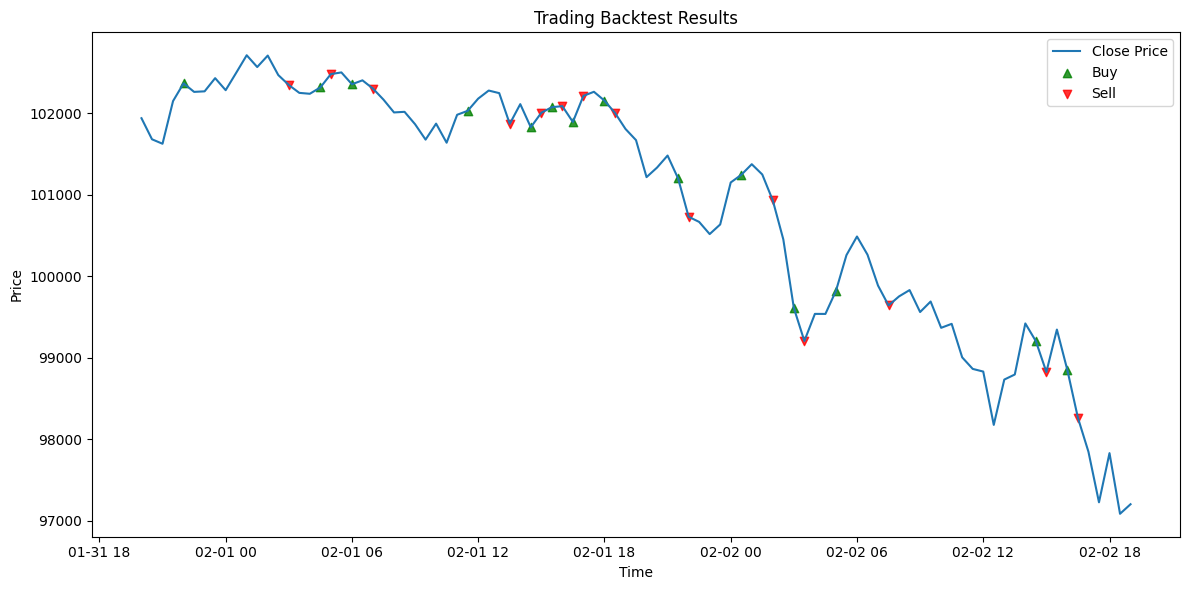

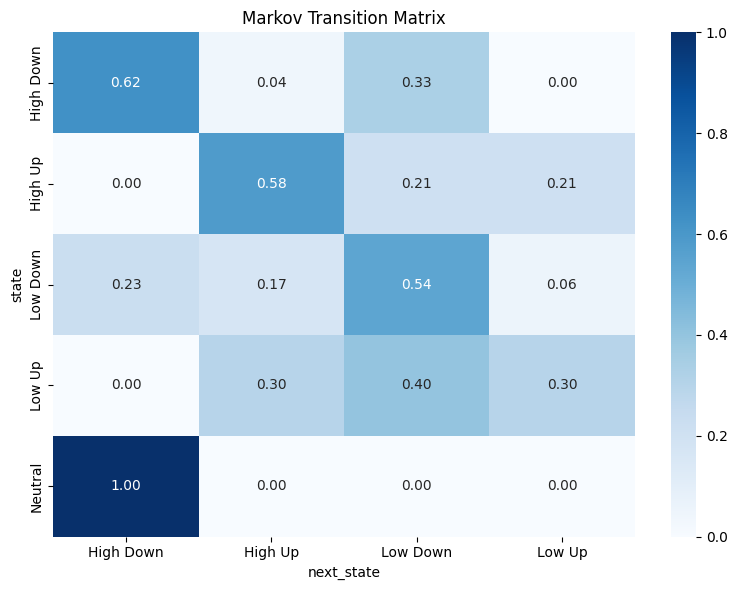

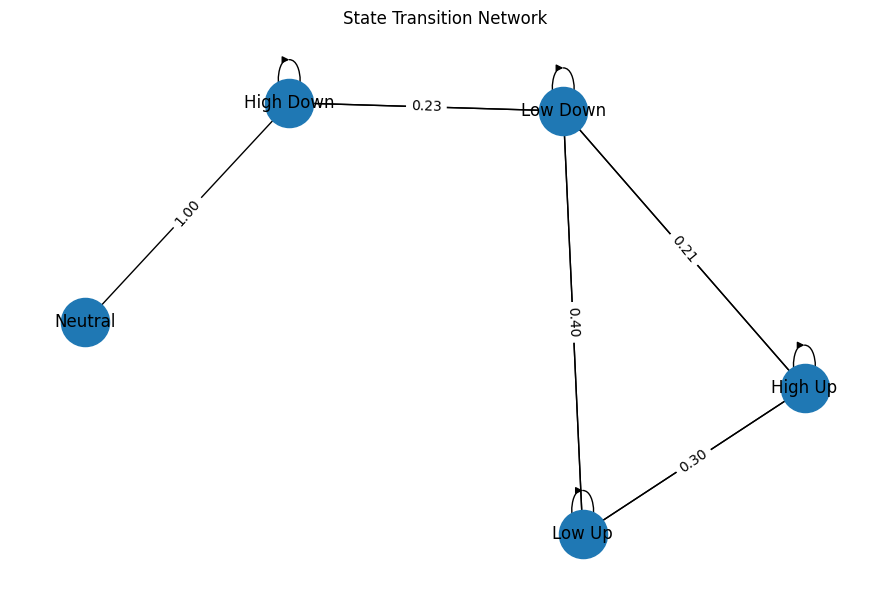

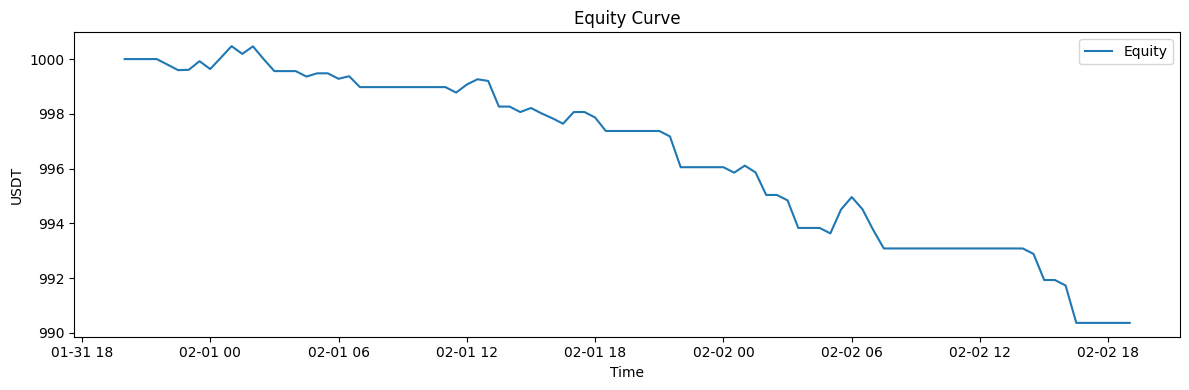

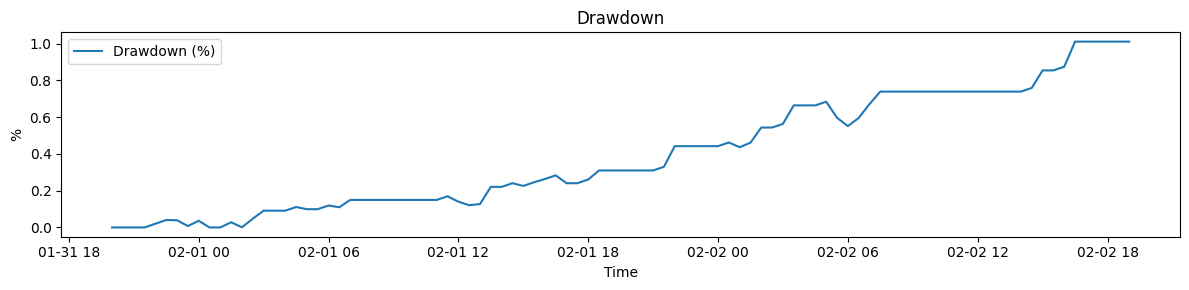

In [ ]:
# 5) Plot charts (run once)
plt.close("all")  # prevents duplicates if you re-run this cell
_ = plot_trades(df2, trades_df, title="Trading Backtest Results")
_ = plot_transition_heatmap(transition_matrix)
_ = plot_transition_network(transition_matrix)
_ = plot_equity(equity_df)